In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'Root/'
width=256
height=256
depth=3

In [3]:

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [66]:
listfile = open("labels.txt", "w")

In [67]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)
    print(root_dir)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}//{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}//{plant_folder}//{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}//{plant_folder}//{plant_disease_folder}//{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
                    listfile.write(plant_disease_folder + "\n")
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
    


[INFO] Loading images ...
['PlantVillage']
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing PlantVillage ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


In [68]:
listfile.close()

In [5]:
label_list

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell___Bacterial_spot',
 'Pepper__bell

In [6]:
image_size = len(image_list)

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
73/73 [==============================] - 259s 4s/step - loss: 0.2065 - accuracy: 0.3847 - val_loss: 0.7866 - val_accuracy: 0.0626
Epoch 2/25
73/73 [==============================] - 251s 3s/step - loss: 0.1694 - accuracy: 0.5019 - val_loss: 1.3847 - val_accuracy: 0.0626
Epoch 3/25
73/73 [==============================] - 250s 3s/step - loss: 0.1392 - accuracy: 0.5796 - val_loss: 1.1237 - val_accuracy: 0.0677
Epoch 4/25
73/73 [==============================] - 252s 3s/step - loss: 0.1229 - accuracy: 0.6453 - val_loss: 1.0979 - val_accuracy: 0.0694
Epoch 5/25
73/73 [==============================] - 296s 4s/step - loss: 0.1130 - accuracy: 0.6733 - val_loss: 0.6964 - val_accuracy: 0.1269
Epoch 6/25
73/73 [==============================] - 252s 3s/step - loss: 0.0953 - accuracy: 0.7192 - val_loss: 0.5974 - val_accuracy: 0.2487
Epoch 7/25
73/73 [==============================] - 250s 3s/step - loss: 0.084

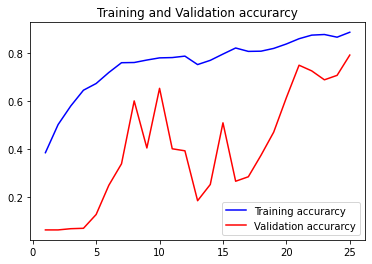

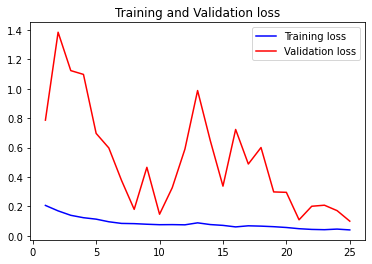

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 7s 355ms/step - loss: 0.0994 - accuracy: 0.7919
Test Accuracy: 79.18781638145447


In [20]:
# print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))

In [24]:
# loaded_model = pickle.load(open('path\\cnn_model.pkl', 'rb'))

In [18]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [19]:
model.save("trainedmodel.h5")